# Recommendation based on collaboration Sports Category

In [1]:
pip install huggingface_hub["cli"]

Note: you may need to restart the kernel to use updated packages.


## Project Overview:
The project focuses on building a recommender system that suggests products to users based on their past ratings and preferences. It employs two main approaches: memory-based collaborative filtering and model-based collaborative filtering.

### Data Loading and Preprocessing:
- Load the dataset containing user ratings for products (presumably from an e-commerce platform).
- Select relevant columns such as reviewerID, asin (product ID), and overall (rating).

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
df= pd.read_csv('t2.csv')
df.head()

,Unnamed: 0,category,description,title,brand,date,price,asin,imageURL,overall,verified,reviewTime,reviewText,reviewerID,Sentimental
0,128,"['Sports & Outdoors', 'Outdoor Recreation', 'C...","[""Rely on delorme ATLAS & gazetteer paper maps...",Garmin DeLorme Atlas &amp; Gazetteer Paper Map...,Garmin,2003-08-04,21.96,0899333257,['https://images-na.ssl-images-amazon.com/imag...,5,False,"01 25, 2008",These Delorme Atlas & Gazetters are wondeful. ...,A2IUHI0QMEC9US,Positive
1,129,"['Sports & Outdoors', 'Outdoor Recreation', 'C...","[""Rely on delorme ATLAS & gazetteer paper maps...",Garmin DeLorme Atlas &amp; Gazetteer Paper Map...,Garmin,2003-08-04,21.96,0899333257,['https://images-na.ssl-images-amazon.com/imag...,3,False,"10 28, 2007",I purchased the maps so I could see the elevat...,APPM2Z3VPETEX,Neutral
2,130,"['Sports & Outdoors', 'Outdoor Recreation', 'C...","[""Rely on delorme ATLAS & gazetteer paper maps...",Garmin DeLorme Atlas &amp; Gazetteer Paper Map...,Garmin,2003-08-04,21.96,0899333257,['https://images-na.ssl-images-amazon.com/imag...,5,True,"05 7, 2007",Great Product! Nearly as good as having a sepe...,A210MD07WALT56,Positive
3,131,"['Sports & Outdoors', 'Outdoor Recreation', 'C...","[""Rely on delorme ATLAS & gazetteer paper maps...",Garmin DeLorme Atlas &amp; Gazetteer Paper Map...,Garmin,2003-08-04,21.96,0899333257,['https://images-na.ssl-images-amazon.com/imag...,5,True,"04 3, 2007",I have nothing but praise for DeLorme. We hav...,A2DTG02DSNOLQY,Positive
4,132,"['Sports & Outdoors', 'Outdoor Recreation', 'C...","[""Rely on delorme ATLAS & gazetteer paper maps...",Garmin DeLorme Atlas &amp; Gazetteer Paper Map...,Garmin,2003-08-04,21.96,0899333257,['https://images-na.ssl-images-amazon.com/imag...,5,True,"02 15, 2007",This is a must have for finding the tucked awa...,A1T4WK0L835QHQ,Positive


In [4]:
df1=df[['reviewerID','asin','overall']][:12000]
df1.head()

,reviewerID,asin,overall
0,A2IUHI0QMEC9US,0899333257,5
1,APPM2Z3VPETEX,0899333257,3
2,A210MD07WALT56,0899333257,5
3,A2DTG02DSNOLQY,0899333257,5
4,A1T4WK0L835QHQ,0899333257,5


## Data Exploration:
Explore basic statistics and visualizations to understand the distribution of ratings and user behavior.

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  2683 non-null   object
 1   asin        2683 non-null   object
 2   overall     2683 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.0+ KB


In [6]:
df1.describe()

,overall
count,2683.000000
mean,4.101006
std,1.344698
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
df1.isnull().sum()

reviewerID    0
asin          0
overall       0
dtype: int64

In [8]:
df1.shape

(2683, 3)

In [9]:
df1.drop_duplicates(inplace=True)

In [10]:
df1.shape

(1415, 3)

C:\Users\prabh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='overall', ylabel='count'>

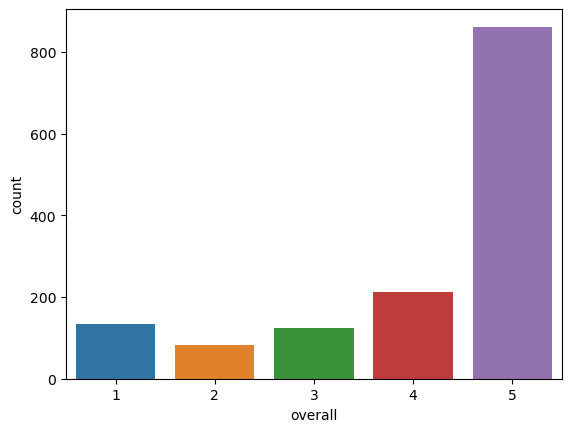

In [11]:
sb.countplot(df1['overall'])

In [12]:
print("total rating =",len(df1['overall']))
print("Total unique users = ",df1['reviewerID'].nunique())
print("Total unique Products = ",df1['asin'].nunique())

total rating = 1415
Total unique users =  1407
Total unique Products =  9


## Memory-Based Collaborative Filtering:
- Calculate the number of rated products per user to understand user engagement.
- Compute the average rating for each product to identify popular products.
- Visualize the distribution of average ratings for products.
- Utilize the Surprise library to implement KNN-based collaborative filtering.
- Train the model using the training set and evaluate its performance using the test set.
- Print the Root Mean Squared Error (RMSE) as a measure of model accuracy.

Analyzing the rating by user

In [13]:
no_of_rated_product_per_user = df1.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_of_rated_product_per_user.head()

reviewerID
A2PXL5ZL7H2S2A    2
A3W1CX78I81IB1    2
A3HL7PXNH88XKB    2
A29YB6HE0TC3QG    2
A164DFPAUWX1BA    2
Name: overall, dtype: int64

<AxesSubplot:xlabel='reviewerID'>

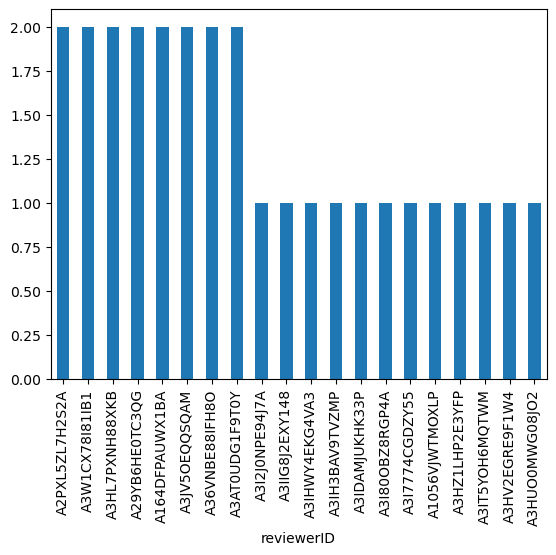

In [14]:
no_of_rated_product_per_user.head(20).plot(kind='bar')

# Average Rating Product

In [15]:
mean_rating_prodcut_count = pd.DataFrame(df1.groupby('asin')['overall'].mean())

In [16]:
mean_rating_prodcut_count.head()

,overall
asin,
0899333257,4.455782
6025006571,4.600000
B00002N6T4,4.507246
B00002N9FI,4.620690
B00004SQMD,1.714286


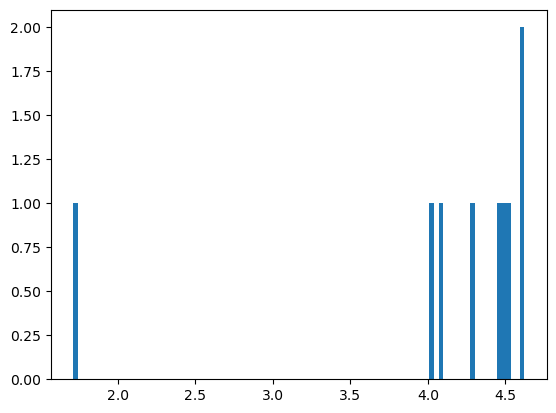

In [17]:
# plot the rating distribution of average rating product
plt.hist(mean_rating_prodcut_count['overall'],bins=100);

In [18]:
mean_rating_prodcut_count['overall'].skew()

-2.700652293692187

In [19]:
#conda install -c conda-forge scikit-surprise 

In [20]:
#conda install -c conda-forge scikit-surprise

In [21]:

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [22]:
reader = Reader(rating_scale=(1,5))
surprise_data = Dataset.load_from_df(df1,reader)

In [23]:
#splitting surprise the dataset into 80:20
train,test= train_test_split(surprise_data,test_size=0.3,random_state=47)

In [24]:
algo = KNNWithMeans(k=5,sim_options={'name':'pearson_baseline','used_based':False})
algo.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [25]:
#make prediction using test
test_pred = algo.test(test)

In [26]:
#print RMSE
print("Item-Based Model : Test set")
accuracy.rmse(test_pred,verbose=True)

Item-Based Model : Test set
RMSE: 1.3775


1.3774690638502614

# Model Based collabrative filtering system
- Create a user-item matrix where rows represent users, columns represent products, and cells contain ratings.
- Transpose the matrix to get an item-user matrix.
- Decompose the item-user matrix using Singular Value Decomposition (SVD) to capture latent factors.
- Compute the correlation matrix between products based on decomposed features.
- Recommend top correlated products for a given product based on correlation threshold.
- Merge recommended products with the original dataset to retrieve additional information such as product titles and ratings.

In [27]:
df1.shape

(1415, 3)

In [28]:
rating_matrix = df1.pivot_table(values='overall',index='reviewerID',columns='asin',fill_value=0)
rating_matrix.head()

asin,0899333257,6025006571,B00002N6T4,B00002N9FI,B00004SQMD,B00004U9IW,B00004YTPE,B00004Z2XT,B000051ZHS
reviewerID,,,,,,,,,
A1056VJWTMOXLP,0,0,0,0,0,0,0,0,5
A106CN52405M9A,0,0,0,0,0,0,0,0,4
A106KQ7U0B4XZB,0,0,0,0,0,0,4,0,0
A10A7IAR5T4F85,0,0,0,0,0,0,0,0,5
A10BVZYYURC24P,0,0,5,0,0,0,0,0,0


above we have created a pivot table of the rating where the value of the column will overall(rating) and index will be userid and the column name will be asin(product id)

In [29]:
rating_matrix.shape

(1407, 9)

In [30]:
# transpose
x_rating_matrix = rating_matrix.T
x_rating_matrix.head()

reviewerID,A1056VJWTMOXLP,A106CN52405M9A,A106KQ7U0B4XZB,A10A7IAR5T4F85,A10BVZYYURC24P,A10FWWCR1P1TEC,A10HSOBGDIL1PL,A10LB6S2BXQ0GD,A10LT9FW6RWG6Y,A10N2G0EJPRP15,...,AZD37ZRPRZF69,AZHQZUYH59SPB,AZI7OLYY5EEX4,AZMR606RD05VM,AZO5N3LM2URDO,AZQP60XPXUQPH,AZR3V3TD5EDL7,AZUVU38922NZO,AZWOOLU6DYGRN,AZYJE40XW6MFG
asin,,,,,,,,,,,,,,,,,,,,,
0899333257,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,3,0,0
6025006571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00002N6T4,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00002N9FI,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
B00004SQMD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
x_rating_matrix.shape

(9, 1407)

In [32]:
# Decomposition of the matrix
from sklearn.decomposition import TruncatedSVD

In [33]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(x_rating_matrix)
decomposed_matrix.shape

(9, 9)

In [34]:
#corelation matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(9, 9)

In [35]:
x_rating_matrix.index[4]

'B00004SQMD'

In [36]:
i="B00004Z2XT"
product_name = list(x_rating_matrix.index)
product_id = product_name.index(i)
print(product_id)

7


In [37]:
correlation_product_id = correlation_matrix[product_id]
correlation_product_id.shape

(9,)

In [38]:
correlation_matrix[correlation_product_id>0.85].shape

(1, 9)

In [39]:
#reccomending top 20 highly correlated products in sequence
recommend = list(x_rating_matrix.index[correlation_product_id > 0.75])
recco=recommend[:20]

In [40]:
rec=pd.DataFrame(recco,columns=['asin'])

In [41]:
final=pd.merge(df,rec,on='asin',how='inner')

In [42]:
final[['title','asin','overall']]

,title,asin,overall
0,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
1,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
2,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
3,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,4
4,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,3
5,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
6,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,4
7,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
8,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,5
9,"Vaughan RB 28-Ounce Rig Builders Hatchet, Hick...",B00004Z2XT,4


## Final Output:
**Display the top recommended products along with their titles and ratings to the user.**

In [44]:
unique_values=final['title'].unique()

In [45]:
unique_values

array(['Vaughan RB 28-Ounce Rig Builders Hatchet, Hickory Handle for heavy construction, 17-Inch Long.'],
      dtype=object)

**These are the recommended product using collabration method**

## Conclusion:
This project aims to provide personalized product recommendations to users by leveraging collaborative filtering techniques. It utilizes both memory-based and model-based approaches to analyze user-item interactions and identify patterns in the data. The final output is a list of recommended products tailored to each user's preferences, thereby enhancing their shopping experience and increasing user engagement.